In [1]:
import numpy as np 
import pandas as pd 
import warnings 
warnings.filterwarnings('ignore') 
import seaborn as sns
import plotly.express as px
from scipy.stats.mstats import trimmed_var
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

### Code Begins: Masoud Rezapour Najafi $ Ferdinand iguodala

In [2]:
# Importing our datasets
transactions_df = pd.read_parquet('TaoYin_User_Transactions_v2.parquet')

In [3]:
transactions_df

,customer,invoice,invoice_date,articlenr,volume,sum1,sum2,postcode_delivery,postcode_customer,channel
0,2284,1187467,2020-01-02,32879960,24,343.73,362.30,80413,80413,Tel 86041
1,2284,1187467,2020-01-02,32879962,60,1067.64,1119.96,80413,80413,Tel 86041
2,2284,1187467,2020-01-02,32841810,120,2214.00,2408.40,80413,80413,Tel 86041
3,1704,1191447,2020-01-17,36866802,1,21.52,19.32,81724,81724,OTC 81812
4,45,1187691,2020-01-03,34360272,4,28.91,28.49,81796,81796,Web Order
...,...,...,...,...,...,...,...,...,...,...
492726,441,1596745,2024-09-19,34100450,4,590.03,619.53,85684,85684,ERP Order
492727,2478,1596752,2024-09-19,37061626,2,23.86,18.94,85711,85711,Web Order
492728,2478,1596752,2024-09-19,32447128,10,27.82,23.54,85711,85711,Web Order
492729,2478,1596752,2024-09-19,32440824,10,4.88,4.13,85711,85711,Web Order


In [4]:
# Calculate the margin by subtracting 'sum1' from 'sum2' and store the result in a new column 'margin'
transactions_df['margin'] = transactions_df['sum2'] - transactions_df['sum1']

In [5]:
transactions_df

,customer,invoice,invoice_date,articlenr,volume,sum1,sum2,postcode_delivery,postcode_customer,channel,margin
0,2284,1187467,2020-01-02,32879960,24,343.73,362.30,80413,80413,Tel 86041,18.57
1,2284,1187467,2020-01-02,32879962,60,1067.64,1119.96,80413,80413,Tel 86041,52.32
2,2284,1187467,2020-01-02,32841810,120,2214.00,2408.40,80413,80413,Tel 86041,194.40
3,1704,1191447,2020-01-17,36866802,1,21.52,19.32,81724,81724,OTC 81812,-2.20
4,45,1187691,2020-01-03,34360272,4,28.91,28.49,81796,81796,Web Order,-0.42
...,...,...,...,...,...,...,...,...,...,...,...
492726,441,1596745,2024-09-19,34100450,4,590.03,619.53,85684,85684,ERP Order,29.50
492727,2478,1596752,2024-09-19,37061626,2,23.86,18.94,85711,85711,Web Order,-4.92
492728,2478,1596752,2024-09-19,32447128,10,27.82,23.54,85711,85711,Web Order,-4.28
492729,2478,1596752,2024-09-19,32440824,10,4.88,4.13,85711,85711,Web Order,-0.75


In [6]:
# Group the transactions by 'customer' and aggregate the data for each customer:
aggregated_df = transactions_df.groupby(by="customer", as_index=False) \
    .agg(
        Monetary=("sum2", "sum"),
        Frequency=("invoice", "nunique"),
        LastInvoiceDate=("invoice_date", "max"),
        TotalVolume=("volume", "sum"),
        TotalMargin=("margin", "sum")         
    )

aggregated_df.head(5)

,customer,Monetary,Frequency,LastInvoiceDate,TotalVolume,TotalMargin
0,0,13.72,1,2020-10-06,1,-2.53
1,3,712214.87,529,2024-09-19,293321,10263.09
2,4,3135.02,39,2024-05-03,1315,-736.60
3,5,2199.45,5,2020-03-06,161,-2220.25
4,6,99.48,2,2021-07-02,3,-8.89


In [7]:
# Calculate the recency for each customer:
max_invoice_date = aggregated_df["LastInvoiceDate"].max()

aggregated_df["Recency"] = (max_invoice_date - aggregated_df["LastInvoiceDate"]).dt.days

aggregated_df.head(5)

,customer,Monetary,Frequency,LastInvoiceDate,TotalVolume,TotalMargin,Recency
0,0,13.72,1,2020-10-06,1,-2.53,1450
1,3,712214.87,529,2024-09-19,293321,10263.09,6
2,4,3135.02,39,2024-05-03,1315,-736.60,145
3,5,2199.45,5,2020-03-06,161,-2220.25,1664
4,6,99.48,2,2021-07-02,3,-8.89,1181


In [8]:
aggregated_df.describe()

,customer,Monetary,Frequency,LastInvoiceDate,TotalVolume,TotalMargin,Recency
count,1070.000000,1.070000e+03,1070.000000,1070,1.070000e+03,1.070000e+03,1070.000000
mean,1296.874766,1.194620e+05,89.250467,2023-03-28 01:38:14.579439360,3.670260e+04,1.244131e+04,546.931776
min,0.000000,0.000000e+00,1.000000,2020-01-03 00:00:00,1.000000e+00,-1.322280e+05,0.000000
25%,755.250000,4.816675e+02,3.000000,2022-02-03 00:00:00,6.650000e+01,-1.267355e+03,76.000000
50%,1287.500000,2.748125e+03,12.000000,2023-11-06 00:00:00,8.235000e+02,-2.022300e+02,324.000000
75%,1909.750000,1.394387e+04,49.750000,2024-07-11 00:00:00,6.353500e+03,-4.345000e+00,965.000000
max,2500.000000,6.343161e+07,6303.000000,2024-09-25 00:00:00,6.003265e+06,1.076710e+07,1727.000000
std,706.017136,1.968933e+06,367.527657,NaN,2.545127e+05,3.345502e+05,535.146863


In [9]:
# Calculate the maximum invoice date from the LastInvoiceDate column
max_invoice_date = aggregated_df["LastInvoiceDate"].max()

# Calculate recency in days
aggregated_df["Recency"] = (max_invoice_date - aggregated_df["LastInvoiceDate"]).dt.days

# Display the first 5 rows of the updated DataFrame
print(aggregated_df.head(5))


   customer   Monetary  Frequency LastInvoiceDate  TotalVolume  TotalMargin  \
0         0      13.72          1      2020-10-06            1        -2.53   
1         3  712214.87        529      2024-09-19       293321     10263.09   
2         4    3135.02         39      2024-05-03         1315      -736.60   
3         5    2199.45          5      2020-03-06          161     -2220.25   
4         6      99.48          2      2021-07-02            3        -8.89   

   Recency  
0     1450  
1        6  
2      145  
3     1664  
4     1181  


In [10]:
aggregated_df

,customer,Monetary,Frequency,LastInvoiceDate,TotalVolume,TotalMargin,Recency
0,0,13.72,1,2020-10-06,1,-2.53,1450
1,3,712214.87,529,2024-09-19,293321,10263.09,6
2,4,3135.02,39,2024-05-03,1315,-736.60,145
3,5,2199.45,5,2020-03-06,161,-2220.25,1664
4,6,99.48,2,2021-07-02,3,-8.89,1181
...,...,...,...,...,...,...,...
1065,2491,2018.17,16,2024-09-12,342,-589.10,13
1066,2492,15763.15,45,2024-05-22,3634,-3160.73,126
1067,2493,497.20,4,2021-10-14,84,25.42,1077
1068,2496,1405.46,8,2023-03-21,117,-472.32,554


<Axes: >

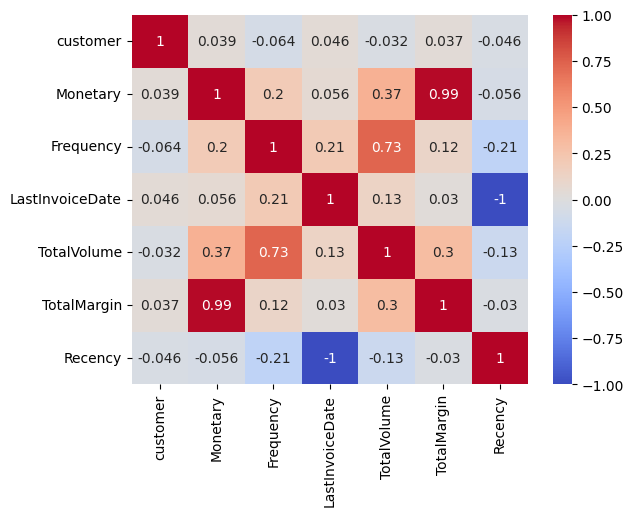

In [11]:
# Create a heatmap to visualize the correlation matrix of the aggregated data
sns.heatmap(aggregated_df.corr(),annot=True,cmap='coolwarm')

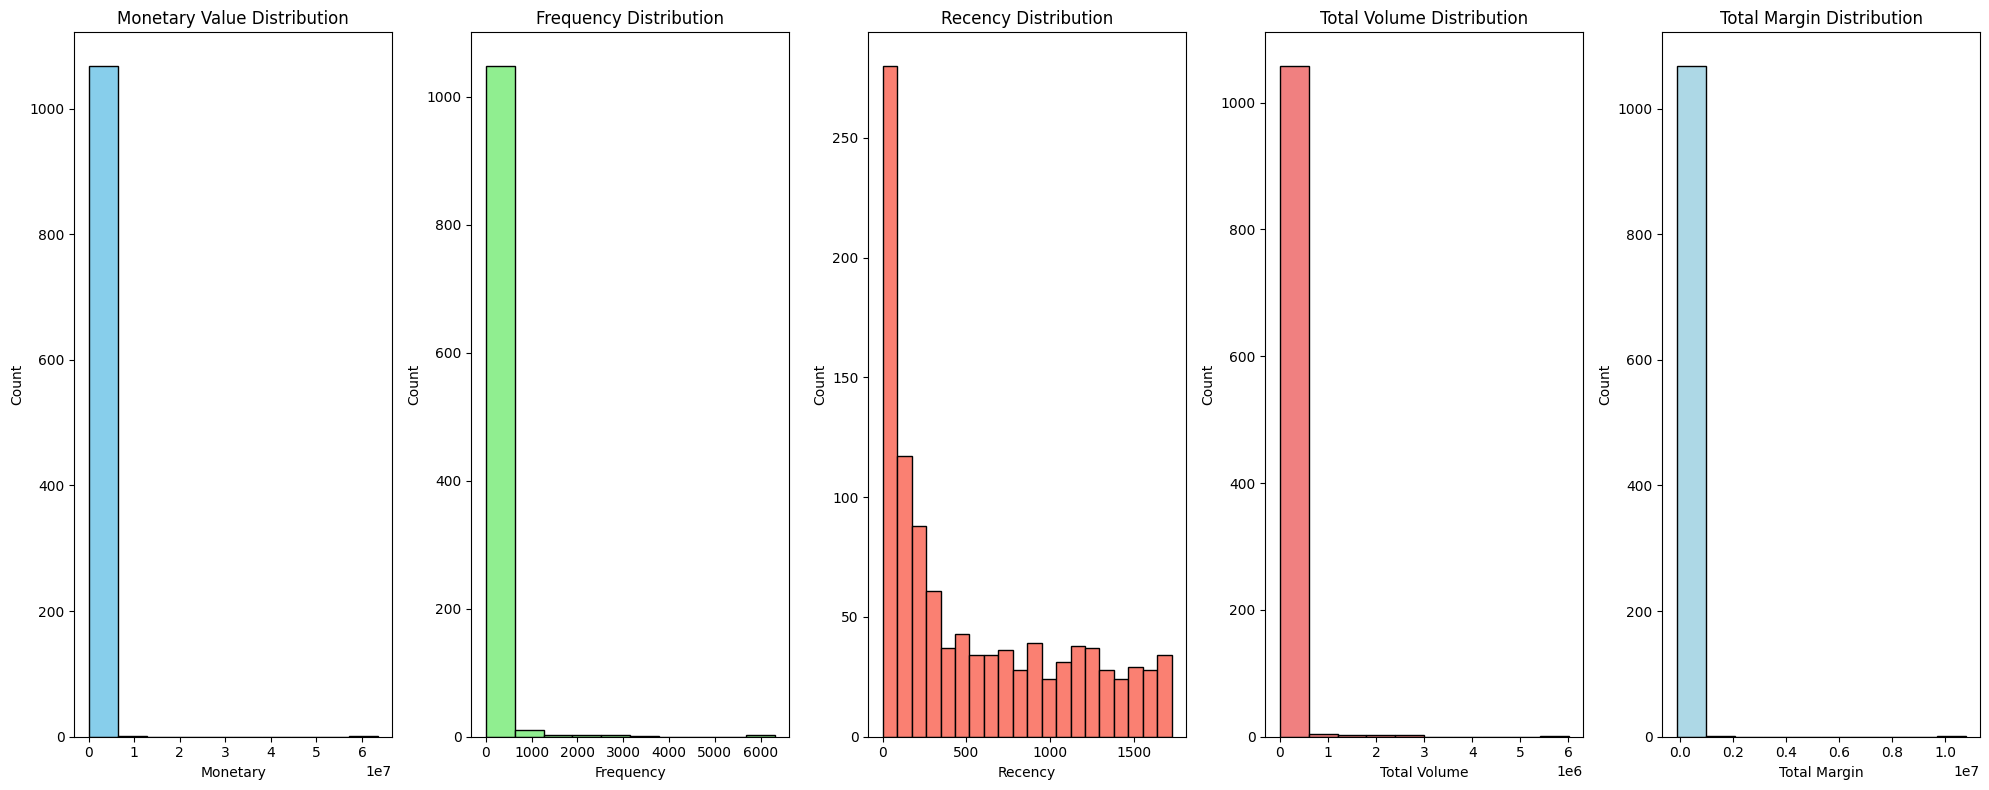

In [12]:
plt.figure(figsize=(20, 8))  # Increased figure size to fit more subplots

# Plot for Monetary Value Distribution
plt.subplot(1, 5, 1)  # Changed to a 1x5 grid
plt.hist(aggregated_df['Monetary'], bins=10, color='skyblue', edgecolor='black')
plt.title('Monetary Value Distribution')
plt.xlabel('Monetary')
plt.ylabel('Count')

# Plot for Frequency Distribution
plt.subplot(1, 5, 2)
plt.hist(aggregated_df['Frequency'], bins=10, color='lightgreen', edgecolor='black')
plt.title('Frequency Distribution')
plt.xlabel('Frequency')
plt.ylabel('Count')

# Plot for Recency Distribution
plt.subplot(1, 5, 3)
plt.hist(aggregated_df['Recency'], bins=20, color='salmon', edgecolor='black')
plt.title('Recency Distribution')
plt.xlabel('Recency')
plt.ylabel('Count')

# Plot for Total Volume Distribution
plt.subplot(1, 5, 4)
plt.hist(aggregated_df['TotalVolume'], bins=10, color='lightcoral', edgecolor='black')
plt.title('Total Volume Distribution')
plt.xlabel('Total Volume')
plt.ylabel('Count')

# Plot for Total Margin Distribution
plt.subplot(1, 5, 5)
plt.hist(aggregated_df['TotalMargin'], bins=10, color='lightblue', edgecolor='black')
plt.title('Total Margin Distribution')
plt.xlabel('Total Margin')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

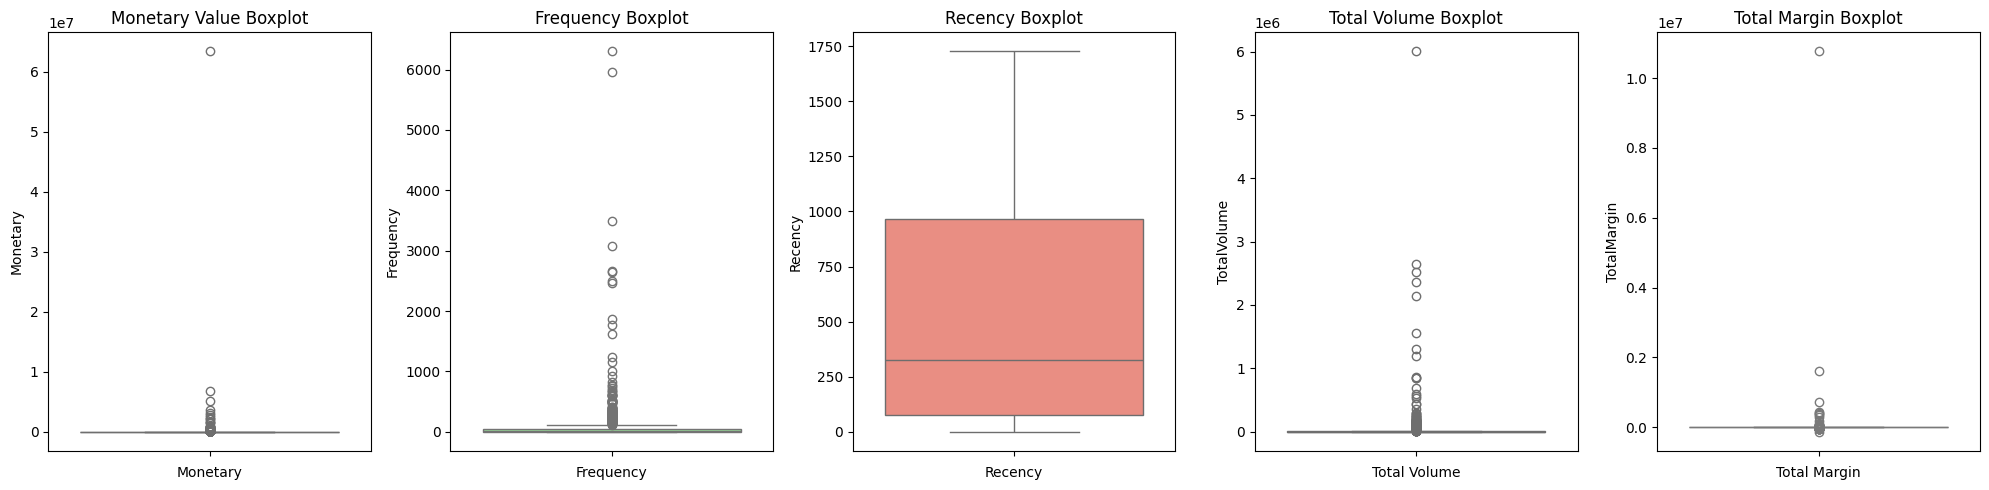

In [13]:
# Set up the figure with an appropriate size for five plots
plt.figure(figsize=(20, 5))

# Boxplot for Monetary Value
plt.subplot(1, 5, 1)
sns.boxplot(data=aggregated_df['Monetary'], color='skyblue')
plt.title('Monetary Value Boxplot')
plt.xlabel('Monetary')

# Boxplot for Frequency
plt.subplot(1, 5, 2)
sns.boxplot(data=aggregated_df['Frequency'], color='lightgreen')
plt.title('Frequency Boxplot')
plt.xlabel('Frequency')

# Boxplot for Recency
plt.subplot(1, 5, 3)
sns.boxplot(data=aggregated_df['Recency'], color='salmon')
plt.title('Recency Boxplot')
plt.xlabel('Recency')

# Boxplot for Total Volume
plt.subplot(1, 5, 4)
sns.boxplot(data=aggregated_df['TotalVolume'], color='lightcoral')
plt.title('Total Volume Boxplot')
plt.xlabel('Total Volume')

# Boxplot for Total Margin
plt.subplot(1, 5, 5)
sns.boxplot(data=aggregated_df['TotalMargin'], color='lightblue')
plt.title('Total Margin Boxplot')
plt.xlabel('Total Margin')

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()


In [14]:
# Calculate the interquartile range (IQR) for the 'Monetary' column to identify outliers:
M_Q1 = aggregated_df["Monetary"].quantile(0.25)
M_Q3 = aggregated_df["Monetary"].quantile(0.75)
M_IQR = M_Q3 - M_Q1

monetary_outliers_df = aggregated_df[(aggregated_df["Monetary"] > (M_Q3 + 1.5 * M_IQR)) | (aggregated_df["Monetary"] < (M_Q1 - 1.5 * M_IQR))].copy()

monetary_outliers_df.describe()

,customer,Monetary,Frequency,LastInvoiceDate,TotalVolume,TotalMargin,Recency
count,173.000000,1.730000e+02,173.000000,173,1.730000e+02,1.730000e+02,173.000000
mean,1259.982659,7.141187e+05,444.052023,2024-06-20 15:07:16.994219776,2.112250e+05,7.983277e+04,96.369942
min,3.000000,3.418907e+04,4.000000,2020-06-30 00:00:00,5.600000e+01,-1.322280e+05,0.000000
25%,600.000000,6.335108e+04,103.000000,2024-06-21 00:00:00,2.248500e+04,-1.461118e+04,1.000000
50%,1215.000000,1.140996e+05,225.000000,2024-09-11 00:00:00,4.990200e+04,-6.493880e+03,14.000000
75%,1936.000000,2.488846e+05,392.000000,2024-09-24 00:00:00,1.428490e+05,4.972700e+02,96.000000
max,2500.000000,6.343161e+07,6303.000000,2024-09-25 00:00:00,6.003265e+06,1.076710e+07,1548.000000
std,768.939216,4.865142e+06,826.534410,NaN,6.047259e+05,8.307579e+05,208.094125


In [15]:
# Calculate the interquartile range (IQR) for the 'Frequency' column to identify outliers:
F_Q1 = aggregated_df['Frequency'].quantile(0.25)
F_Q3 = aggregated_df['Frequency'].quantile(0.75)
F_IQR = F_Q3 - F_Q1

frequency_outliers_df = aggregated_df[(aggregated_df['Frequency'] > (F_Q3 + 1.5 * F_IQR)) | (aggregated_df['Frequency'] < (F_Q1 - 1.5 * F_IQR))].copy()

frequency_outliers_df.describe()

,customer,Monetary,Frequency,LastInvoiceDate,TotalVolume,TotalMargin,Recency
count,140.000000,1.400000e+02,140.000000,140,1.400000e+02,1.400000e+02,140.000000
mean,1266.392857,8.434543e+05,545.807143,2024-07-16 00:51:25.714285824,2.423862e+05,9.853678e+04,70.964286
min,3.000000,8.369500e+03,120.000000,2022-03-25 00:00:00,3.018000e+03,-6.401244e+04,0.000000
25%,579.250000,6.015860e+04,186.000000,2024-07-16 00:00:00,2.543800e+04,-1.564335e+04,1.000000
50%,1255.500000,1.220451e+05,277.500000,2024-09-17 00:00:00,5.914700e+04,-6.590515e+03,8.000000
75%,1952.250000,2.849218e+05,492.250000,2024-09-24 00:00:00,1.532182e+05,2.992925e+02,71.000000
max,2488.000000,6.343161e+07,6303.000000,2024-09-25 00:00:00,6.003265e+06,1.076710e+07,915.000000
std,778.429203,5.403299e+06,890.331253,NaN,6.634944e+05,9.226971e+05,156.052768


In [16]:
# Calculate outliers for TotalVolume
TV_Q1 = aggregated_df['TotalVolume'].quantile(0.25)
TV_Q3 = aggregated_df['TotalVolume'].quantile(0.75)
TV_IQR = TV_Q3 - TV_Q1

total_volume_outliers_df = aggregated_df[(aggregated_df['TotalVolume'] > (TV_Q3 + 1.5 * TV_IQR)) | 
                                          (aggregated_df['TotalVolume'] < (TV_Q1 - 1.5 * TV_IQR))].copy()

print("Total Volume Outliers:")
print(total_volume_outliers_df.describe())

Total Volume Outliers:
          customer      Monetary    Frequency                LastInvoiceDate  \
count   176.000000  1.760000e+02   176.000000                            176   
mean   1325.045455  6.839157e+05   429.909091  2024-05-27 11:10:54.545454592   
min       3.000000  7.885190e+03    27.000000            2020-12-22 00:00:00   
25%     697.500000  3.809516e+04    88.500000            2024-06-06 00:00:00   
50%    1343.000000  9.506646e+04   201.000000            2024-09-10 00:00:00   
75%    1969.500000  2.074435e+05   384.250000            2024-09-24 00:00:00   
max    2500.000000  6.343161e+07  6303.000000            2024-09-25 00:00:00   
std     753.667830  4.826009e+06   823.168126                            NaN   

        TotalVolume   TotalMargin      Recency  
count  1.760000e+02  1.760000e+02   176.000000  
mean   2.131657e+05  7.777603e+04   120.534091  
min    1.592100e+04 -6.401244e+04     0.000000  
25%    2.875225e+04 -1.312132e+04     1.000000  
50%    5.37

In [17]:
# Calculate outliers for TotalMargin
TM_Q1 = aggregated_df['TotalMargin'].quantile(0.25)
TM_Q3 = aggregated_df['TotalMargin'].quantile(0.75)
TM_IQR = TM_Q3 - TM_Q1

total_margin_outliers_df = aggregated_df[(aggregated_df['TotalMargin'] > (TM_Q3 + 1.5 * TM_IQR)) | 
                                         (aggregated_df['TotalMargin'] < (TM_Q1 - 1.5 * TM_IQR))].copy()

print("Total Margin Outliers:")
print(total_margin_outliers_df.describe())

Total Margin Outliers:
          customer      Monetary    Frequency                LastInvoiceDate  \
count   201.000000  2.010000e+02   201.000000                            201   
mean   1276.716418  6.042480e+05   371.651741  2024-05-19 02:37:36.716417792   
min       3.000000  3.230000e+03     1.000000            2020-06-30 00:00:00   
25%     602.000000  3.491681e+04    70.000000            2024-06-05 00:00:00   
50%    1275.000000  8.474107e+04   164.000000            2024-09-04 00:00:00   
75%    1969.000000  1.932742e+05   340.000000            2024-09-23 00:00:00   
max    2500.000000  6.343161e+07  6303.000000            2024-09-25 00:00:00   
std     765.789119  4.518346e+06   763.638768                            NaN   

        TotalVolume   TotalMargin      Recency  
count  2.010000e+02  2.010000e+02   201.000000  
mean   1.739013e+05  6.806049e+04   128.890547  
min    4.110000e+02 -1.322280e+05     0.000000  
25%    1.122100e+04 -1.302500e+04     2.000000  
50%    3.52

In [18]:
# Combine non-outlier dataframes
non_outliers_df = aggregated_df[(~aggregated_df.index.isin(monetary_outliers_df.index)) & 
                                 (~aggregated_df.index.isin(frequency_outliers_df.index)) & 
                                 (~aggregated_df.index.isin(total_volume_outliers_df.index)) & 
                                 (~aggregated_df.index.isin(total_margin_outliers_df.index))]

print("Non-Outliers DataFrame Description:")
print(non_outliers_df.describe())

Non-Outliers DataFrame Description:
          customer      Monetary   Frequency                LastInvoiceDate  \
count   815.000000    815.000000  815.000000                            815   
mean   1309.328834   3298.742834   14.933742  2022-11-22 23:31:43.803681024   
min       0.000000      0.000000    1.000000            2020-01-03 00:00:00   
25%     789.000000    283.125000    2.000000            2021-07-29 00:00:00   
50%    1294.000000   1279.420000    7.000000            2023-03-24 00:00:00   
75%    1901.500000   4146.200000   19.000000            2024-03-26 12:00:00   
max    2496.000000  30804.860000  111.000000            2024-09-25 00:00:00   
std     688.403253   4758.293881   20.253747                            NaN   

        TotalVolume  TotalMargin      Recency  
count    815.000000   815.000000   815.000000  
mean    1487.298160  -378.275583   672.019632  
min        1.000000 -3160.730000     0.000000  
25%       26.500000  -579.730000   182.500000  
50%      293

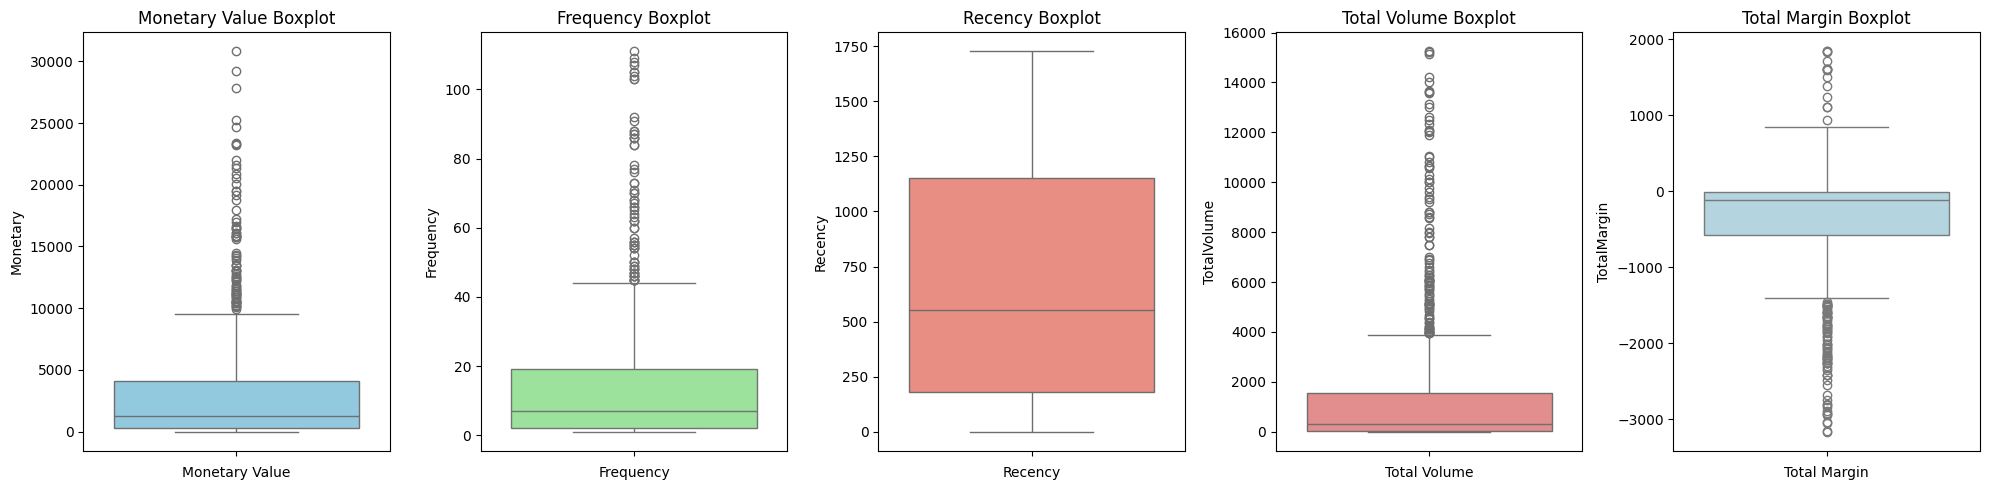

In [19]:
# Set up the figure size for five plots
plt.figure(figsize=(20, 5))  # Increased width to accommodate five boxplots

# Boxplot for Monetary Value
plt.subplot(1, 5, 1)  # Adjusted to a 1x5 grid
sns.boxplot(data=non_outliers_df['Monetary'], color='skyblue')
plt.title('Monetary Value Boxplot')
plt.xlabel('Monetary Value')

# Boxplot for Frequency
plt.subplot(1, 5, 2)
sns.boxplot(data=non_outliers_df['Frequency'], color='lightgreen')
plt.title('Frequency Boxplot')
plt.xlabel('Frequency')

# Boxplot for Recency
plt.subplot(1, 5, 3)
sns.boxplot(data=non_outliers_df['Recency'], color='salmon')
plt.title('Recency Boxplot')
plt.xlabel('Recency')

# Boxplot for Total Volume
plt.subplot(1, 5, 4)
sns.boxplot(data=non_outliers_df['TotalVolume'], color='lightcoral')
plt.title('Total Volume Boxplot')
plt.xlabel('Total Volume')

# Boxplot for Total Margin
plt.subplot(1, 5, 5)
sns.boxplot(data=non_outliers_df['TotalMargin'], color='lightblue')
plt.title('Total Margin Boxplot')
plt.xlabel('Total Margin')

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()


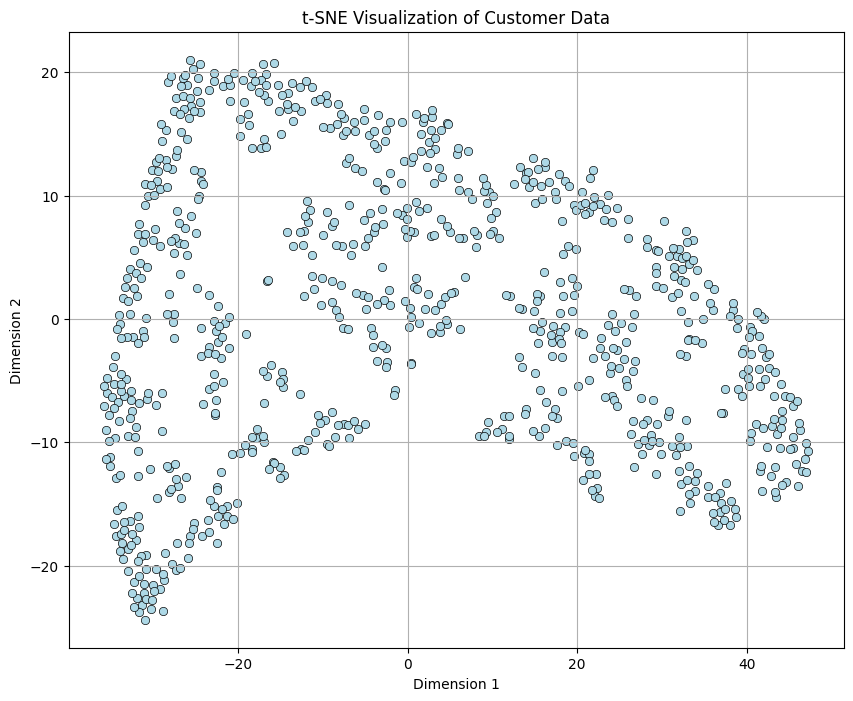

In [20]:
# Select features for t-SNE
features = non_outliers_df[['Monetary', 'Frequency', 'Recency', 'TotalVolume', 'TotalMargin']]

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(features)

# Create a DataFrame for the t-SNE results
tsne_df = pd.DataFrame(tsne_results, columns=['Dimension 1', 'Dimension 2'])

# Plotting the t-SNE results
plt.figure(figsize=(10, 8))
sns.scatterplot(data=tsne_df, x='Dimension 1', y='Dimension 2', color='lightblue', edgecolor='black')
plt.title('t-SNE Visualization of Customer Data')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.grid(True)
plt.show()


Standard scaling transforms the features of your data to have a mean of 0 and a standard deviation of 1, ensuring that each feature contributes equally to the analysis.

$$
z = \frac{x - \mu}{\sigma}
$$

Where:
- $z$ is the standardized value,
- $x$ is the original value,
- $\mu$ is the mean of the feature,
- $\sigma$ is the standard deviation of the feature.

In [21]:
# Initialize the scaler
scaler = StandardScaler()

# Scale the selected features
scaled_data = scaler.fit_transform(non_outliers_df[["Monetary", "Frequency", "Recency", "TotalVolume", "TotalMargin"]])

# Create a DataFrame from the scaled data
scaled_data_df = pd.DataFrame(scaled_data, index=non_outliers_df.index, columns=["Monetary", "Frequency", "Recency", "TotalVolume", "TotalMargin"])

# Display the scaled DataFrame
scaled_data_df

,Monetary,Frequency,Recency,TotalVolume,TotalMargin
0,-0.690802,-0.688381,1.454306,-0.545997,0.529459
2,-0.034429,1.188967,-0.985177,-0.063294,-0.504911
3,-0.231169,-0.490766,1.854344,-0.487221,-2.595504
4,-0.672768,-0.638977,0.951455,-0.545263,0.520497
6,-0.650410,-0.638977,1.097263,-0.530201,-1.414054
...,...,...,...,...,...
1063,-0.665904,-0.688381,1.031837,-0.544161,0.410757
1065,-0.269290,0.052677,-1.231929,-0.420730,-0.297070
1066,2.621120,1.485390,-1.020694,0.788599,-3.920723
1067,-0.589132,-0.540169,0.757044,-0.515507,0.568843


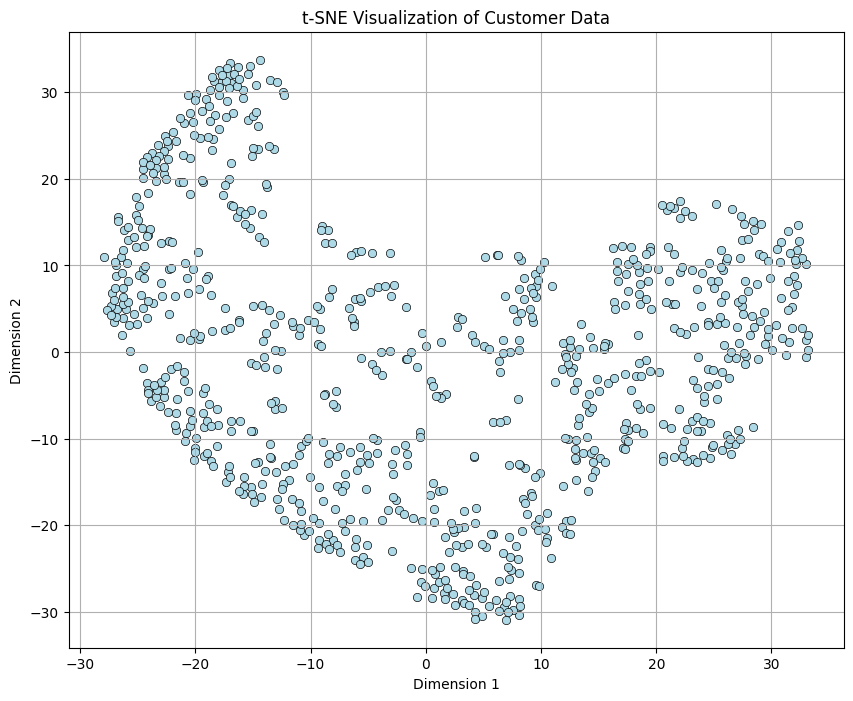

In [22]:
# Select features for t-SNE
features = scaled_data_df[['Monetary', 'Frequency', 'Recency', 'TotalVolume', 'TotalMargin']]

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(features)

# Create a DataFrame for the t-SNE results
tsne_df = pd.DataFrame(tsne_results, columns=['Dimension 1', 'Dimension 2'])

# Plotting the t-SNE results
plt.figure(figsize=(10, 8))
sns.scatterplot(data=tsne_df, x='Dimension 1', y='Dimension 2', color='lightblue', edgecolor='black')
plt.title('t-SNE Visualization of Customer Data')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.grid(True)
plt.show()

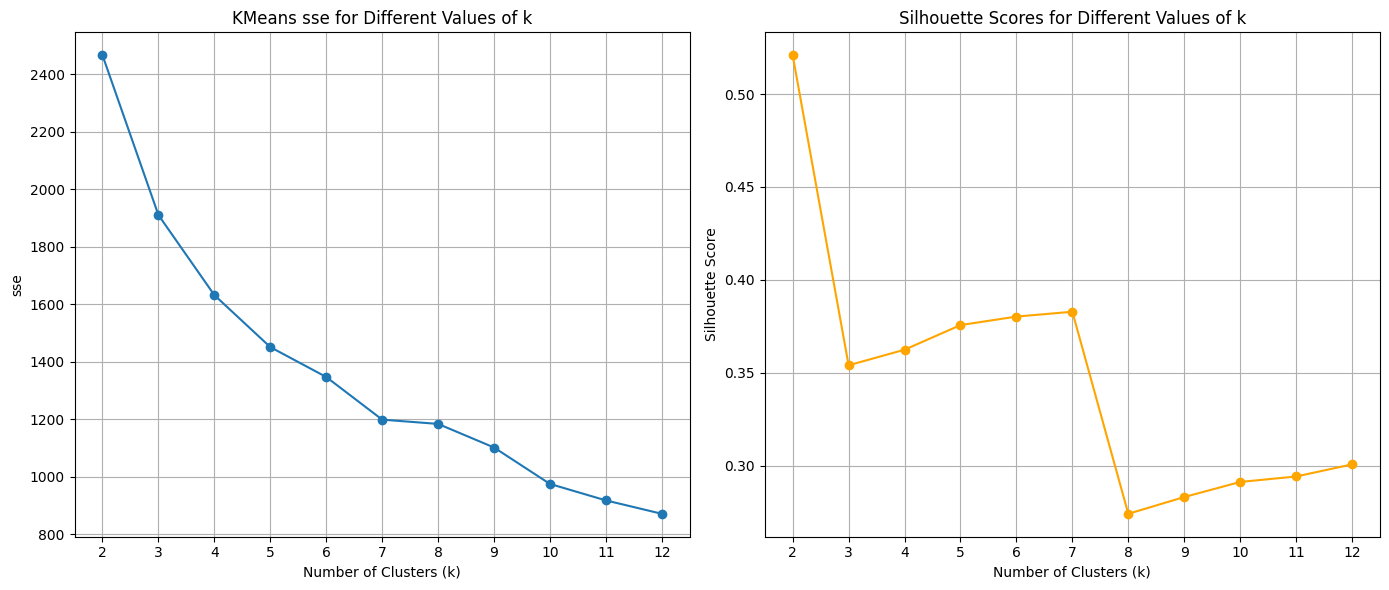

In [23]:
max_k = 12

sse = []
silhoutte_scores = []
k_values = range(2, max_k + 1)

for k in k_values:

    kmeans = KMeans(n_clusters=k, random_state=42, max_iter=1000)

    cluster_labels = kmeans.fit_predict(scaled_data_df)

    sil_score = silhouette_score(scaled_data_df, cluster_labels)

    silhoutte_scores.append(sil_score)

    sse.append(kmeans.inertia_)

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(k_values, sse, marker='o')
plt.title('KMeans sse for Different Values of k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('sse')
plt.xticks(k_values)
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(k_values, silhoutte_scores, marker='o', color='orange')
plt.title('Silhouette Scores for Different Values of k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.xticks(k_values)
plt.grid(True)

plt.tight_layout()
plt.show()

### Sum of Squared Errors (SSE)

$$
\text{SSE} = \sum_{i=1}^{k} \sum_{x_j \in C_i} \|x_j - \mu_i\|^2
$$

Where:
- $\text{SSE}$ is the sum of squared errors for all clusters.
- $k$ is the number of clusters.
- $C_i$ is the set of points in cluster $i$.
- $x_j$ is a data point in cluster $C_i$.
- $\mu_i$ is the centroid of cluster $C_i$.

The SSE value indicates how compact the clusters are; a lower SSE suggests better clustering quality.

### Importance of SSE
- **Elbow Method**: By plotting SSE against different values of $k$, you can identify the optimal number of clusters. Look for the "elbow" point where the rate of decrease sharply changes.



### Silhouette Score

$$
s(i) = \frac{b(i) - a(i)}{\max(a(i), b(i))}
$$

Where:
- $s(i)$ is the silhouette score for a single sample $i$
- $a(i)$ is the average distance between $i$ and all other points in the same cluster,
- $b(i)$ is the minimum average distance between $i$ and all points in the nearest cluster to which $i$ does not belong.

The silhoutte score ranges between $[-1, 1]$, a higher value indicates more distinct clusters.

In [24]:
# Initialize the KMeans clustering model with 7 clusters, a random seed of 42 for reproducibility, 
# and a maximum of 1000 iterations for convergence.
kmeans = KMeans(n_clusters=7, random_state=42, max_iter=1000)

# Fit the KMeans model to the scaled data and predict the cluster labels for each data point.
cluster_labels = kmeans.fit_predict(scaled_data_df)

cluster_labels

array([1, 6, 1, 1, 1, 1, 4, 1, 4, 1, 4, 4, 4, 0, 1, 1, 4, 4, 1, 4, 4, 1,
       1, 4, 1, 1, 2, 6, 1, 1, 1, 0, 2, 4, 6, 4, 0, 1, 1, 4, 6, 1, 3, 2,
       4, 1, 6, 1, 4, 2, 4, 1, 6, 4, 6, 2, 4, 4, 1, 1, 1, 1, 0, 1, 1, 2,
       4, 2, 4, 1, 1, 6, 4, 6, 1, 4, 1, 1, 4, 4, 1, 1, 6, 1, 6, 4, 1, 1,
       1, 1, 2, 4, 6, 3, 2, 4, 4, 1, 6, 1, 1, 1, 0, 1, 2, 1, 4, 1, 1, 4,
       1, 6, 1, 4, 1, 6, 4, 4, 4, 4, 4, 4, 1, 1, 1, 4, 4, 4, 1, 4, 4, 1,
       6, 1, 1, 4, 1, 4, 6, 1, 6, 6, 4, 1, 0, 5, 1, 1, 0, 4, 1, 4, 6, 0,
       2, 1, 4, 6, 4, 4, 4, 1, 1, 4, 2, 4, 1, 1, 1, 1, 4, 4, 1, 1, 4, 1,
       4, 4, 1, 1, 4, 1, 1, 1, 6, 1, 5, 3, 1, 1, 3, 1, 1, 1, 2, 3, 1, 1,
       4, 1, 4, 6, 4, 0, 4, 4, 6, 4, 1, 1, 3, 1, 6, 4, 2, 4, 3, 1, 3, 4,
       4, 4, 1, 3, 1, 1, 4, 4, 4, 3, 4, 4, 5, 1, 4, 3, 4, 0, 4, 4, 1, 1,
       1, 0, 4, 4, 6, 1, 4, 1, 4, 4, 6, 4, 2, 1, 1, 4, 4, 3, 1, 1, 1, 4,
       4, 4, 4, 1, 1, 4, 4, 2, 4, 1, 4, 4, 4, 4, 4, 1, 1, 1, 4, 4, 1, 1,
       4, 2, 4, 2, 4, 4, 4, 1, 1, 1, 1, 4, 4, 4, 2,

In [25]:
# Assign the predicted cluster labels to the 'Cluster' column in the 'non_outliers_df' DataFrame
non_outliers_df["Cluster"] = cluster_labels

non_outliers_df

,customer,Monetary,Frequency,LastInvoiceDate,TotalVolume,TotalMargin,Recency,Cluster
0,0,13.72,1,2020-10-06,1,-2.53,1450,1
2,4,3135.02,39,2024-05-03,1315,-736.60,145,6
3,5,2199.45,5,2020-03-06,161,-2220.25,1664,1
4,6,99.48,2,2021-07-02,3,-8.89,1181,1
6,17,205.80,2,2021-04-15,44,-1381.80,1259,1
...,...,...,...,...,...,...,...,...
1063,2487,132.12,1,2021-05-20,6,-86.77,1224,1
1065,2491,2018.17,16,2024-09-12,342,-589.10,13,4
1066,2492,15763.15,45,2024-05-22,3634,-3160.73,126,2
1067,2493,497.20,4,2021-10-14,84,25.42,1077,1


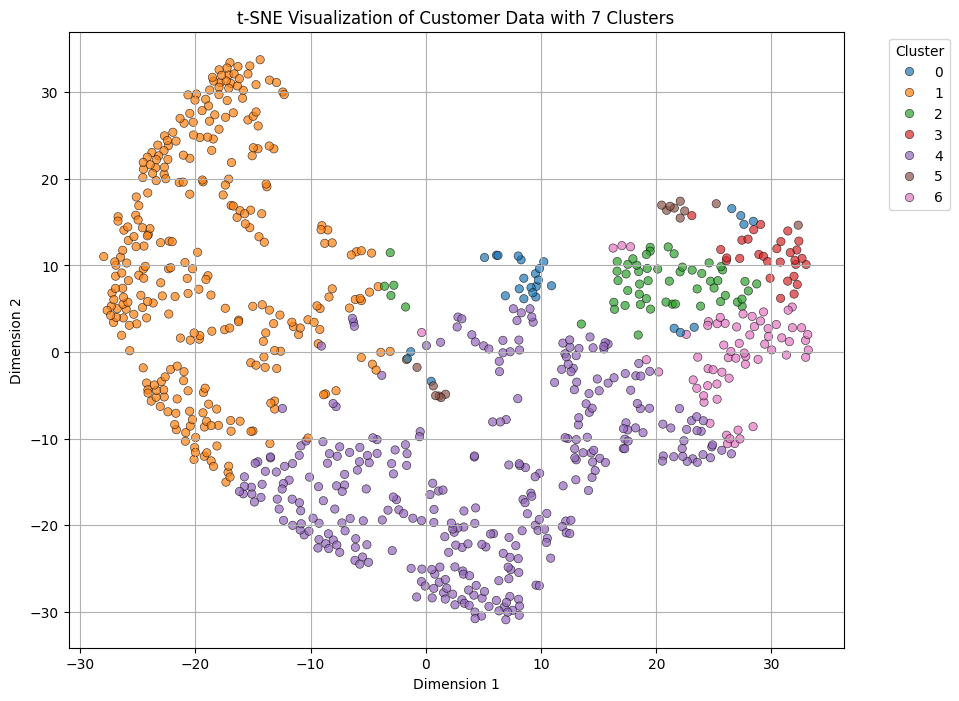

In [26]:
# Use the already standardized features
features = scaled_data_df[['Monetary', 'Frequency', 'Recency', 'TotalVolume', 'TotalMargin']]

# Perform K-Means clustering with 7 clusters
n_clusters = 7
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(features)

# Apply t-SNE for dimensionality reduction
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(features)

# Create a DataFrame for the t-SNE results
tsne_df = pd.DataFrame(tsne_results, columns=['Dimension 1', 'Dimension 2'])

# Add cluster labels to the t-SNE DataFrame
tsne_df['Cluster'] = clusters

# Plotting the t-SNE results with a distinct color palette for 7 clusters
plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=tsne_df, 
    x='Dimension 1', 
    y='Dimension 2', 
    hue='Cluster', 
    palette='tab10',  # Use a distinct color palette
    edgecolor='black', 
    alpha=0.7
)

plt.title('t-SNE Visualization of Customer Data with 7 Clusters')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.grid(True)
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')  # Show legend outside the plot
plt.show()

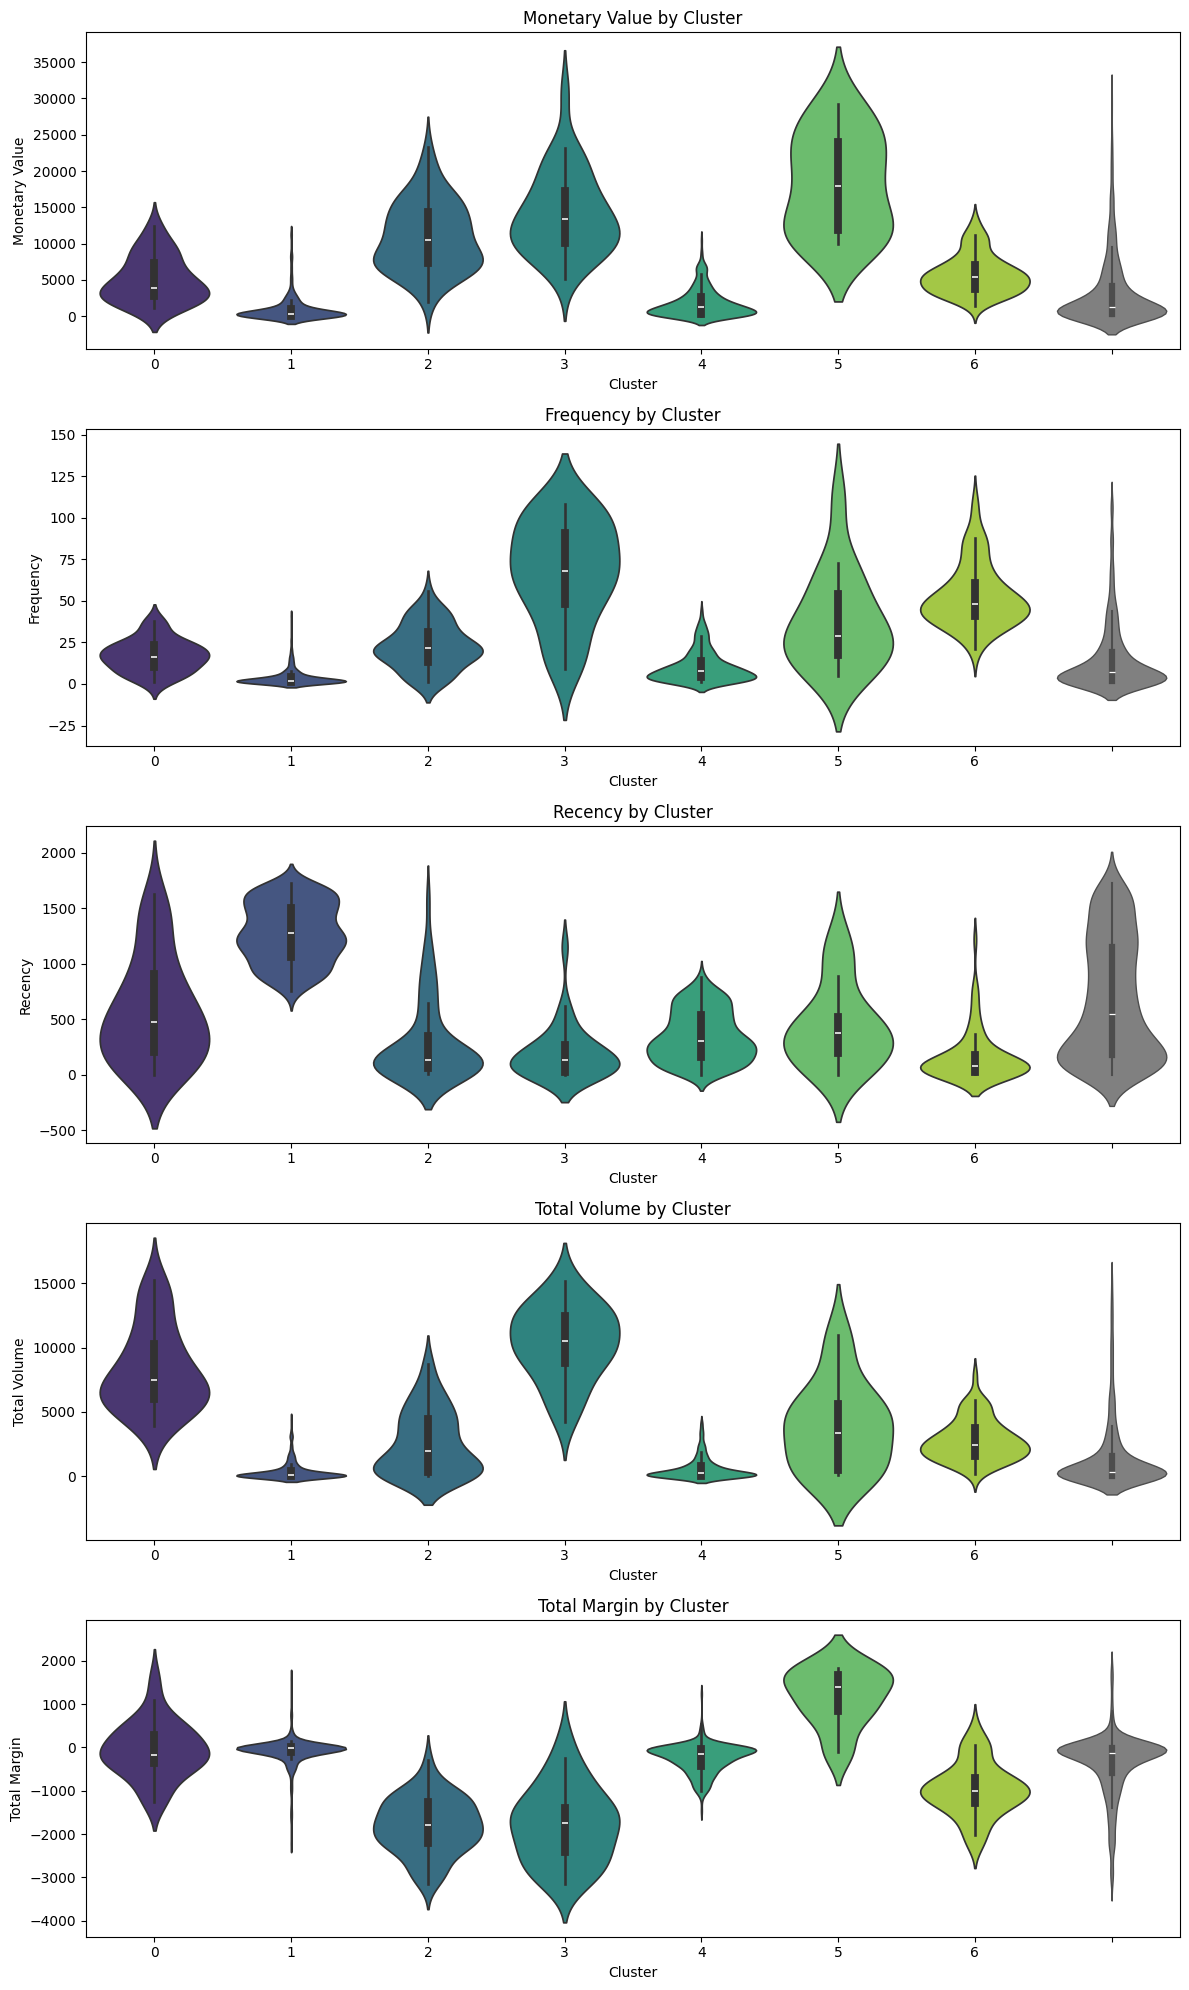

In [27]:
# Set up the color palette for clusters
cluster_colors = sns.color_palette("viridis", n_colors=len(non_outliers_df['Cluster'].unique()))

# Create the figure
plt.figure(figsize=(12, 20))  # Adjust height to accommodate more plots

# Plot for Monetary Value
plt.subplot(5, 1, 1)  # 5 rows, 1 column, first subplot
sns.violinplot(x=non_outliers_df['Cluster'], y=non_outliers_df['Monetary'], palette=cluster_colors)
sns.violinplot(y=non_outliers_df['Monetary'], color='gray', linewidth=1.0)  # Add gray violin for overall distribution
plt.title('Monetary Value by Cluster')
plt.ylabel('Monetary Value')

# Plot for Frequency
plt.subplot(5, 1, 2)  # 5 rows, 1 column, second subplot
sns.violinplot(x=non_outliers_df['Cluster'], y=non_outliers_df['Frequency'], palette=cluster_colors)
sns.violinplot(y=non_outliers_df['Frequency'], color='gray', linewidth=1.0)  # Add gray violin for overall distribution
plt.title('Frequency by Cluster')
plt.ylabel('Frequency')

# Plot for Recency
plt.subplot(5, 1, 3)  # 5 rows, 1 column, third subplot
sns.violinplot(x=non_outliers_df['Cluster'], y=non_outliers_df['Recency'], palette=cluster_colors)
sns.violinplot(y=non_outliers_df['Recency'], color='gray', linewidth=1.0)  # Add gray violin for overall distribution
plt.title('Recency by Cluster')
plt.ylabel('Recency')

# Plot for Total Volume
plt.subplot(5, 1, 4)  # 5 rows, 1 column, fourth subplot
sns.violinplot(x=non_outliers_df['Cluster'], y=non_outliers_df['TotalVolume'], palette=cluster_colors)
sns.violinplot(y=non_outliers_df['TotalVolume'], color='gray', linewidth=1.0)  # Add gray violin for overall distribution
plt.title('Total Volume by Cluster')
plt.ylabel('Total Volume')

# Plot for Total Margin
plt.subplot(5, 1, 5)  # 5 rows, 1 column, fifth subplot
sns.violinplot(x=non_outliers_df['Cluster'], y=non_outliers_df['TotalMargin'], palette=cluster_colors)
sns.violinplot(y=non_outliers_df['TotalMargin'], color='gray', linewidth=1.0)  # Add gray violin for overall distribution
plt.title('Total Margin by Cluster')
plt.ylabel('Total Margin')

# Adjust layout
plt.tight_layout()
plt.show()


# Cluster Analysis and Recommended Strategies

This analysis categorizes each customer segment based on **Monetary Value**, **Frequency**, **Recency**, **Total Volume**, and **Total Margin**. Each cluster has been assigned a descriptive label based on their behaviors and characteristics, along with recommended strategies to maximize engagement and revenue.

| Cluster | Label                                   | Description                                                                                                                   | Recommended Strategy                                                                                               |
|---------|-----------------------------------------|-------------------------------------------------------------------------------------------------------------------------------|--------------------------------------------------------------------------------------------------------------------|
| 0       | **High-Value Inactive Customers**       | High monetary and volume values, but high recency (indicating they haven’t purchased in a while). Moderate frequency and margin. Likely to be high-value customers who have recently disengaged. | **Re-engagement Campaign**: Send personalized reactivation offers, emphasizing the benefits of returning. Include loyalty rewards or exclusive offers to win back their business. |
| 1       | **Low Engagement, Low Value**           | Low across all metrics, with the lowest frequency and low monetary value, volume, and margin. These customers are minimally engaged and contribute the least to overall revenue. | **Cost-Efficient Marketing**: Use low-cost re-engagement tactics, such as automated emails with discounts or promotions. Test different offers to see if they respond to discounts, but minimize marketing spend due to low engagement. |
| 2       | **Price-Sensitive Occasional Shoppers** | Low to moderate in monetary value and margin, with slightly higher recency. Moderate frequency and volume indicate occasional engagement. Likely attracted by promotions or discounts. | **Promotions and Discounts**: Use targeted promotions or loyalty programs to increase engagement. Emphasize value for money and highlight any ongoing discounts to encourage repeat purchases. |
| 3       | **Frequent, High-Value Retail Customers** | High frequency and relatively high monetary value, with moderate volume and margin. These customers shop frequently and have a steady revenue contribution. | **Loyalty Program & Upselling**: Implement a rewards program to encourage ongoing loyalty. Consider upselling and cross-selling to increase average order value, as they already engage regularly. |
| 4       | **High-Volume, Low Margin Buyers**      | High volume with relatively low margin, moderate recency, and frequency. Likely bulk buyers who receive discounts, reducing overall profitability. | **Volume-Based Retention Strategy**: Maintain engagement with volume-based discounts or special offers for high-volume purchases. Explore cross-selling to improve profitability without compromising volume sales. |
| 5       | **Premium, High-Margin Customers**      | High monetary value, high margin, and moderate frequency. Low recency indicates they may still be somewhat active. High-value buyers with a strong profit contribution. | **VIP Treatment & Retention**: Offer exclusive perks and a VIP experience to ensure loyalty. Consider early access to new products, priority support, or a personal account manager for enhanced service. |
| 6       | **Infrequent, High-Margin Niche Buyers**| Moderate to high monetary value, high margin, but very low frequency and high recency. Likely to be niche customers who purchase occasionally but with high profitability. | **Specialized Re-engagement Campaign**: Engage them with tailored offers that align with their niche interests. Highlight any limited editions or exclusive products to appeal to their selective purchasing behavior. |

---

### Detailed Analysis and Strategy Recommendations

Here’s a deeper look into each cluster, with specific business actions for optimizing engagement based on their unique profiles:

- **Cluster 0**: **High-Value Inactive Customers**
  - **Characteristics**: These customers have high historical spending and volume, suggesting they once had a strong business relationship but are now inactive.
  - **Strategy**: **Re-engagement Campaign**. Reach out with personalized offers or loyalty incentives, such as special discounts for returning customers or a “We Miss You” campaign. Highlight what they loved previously to rekindle their interest.

- **Cluster 1**: **Low Engagement, Low Value**
  - **Characteristics**: Low in all metrics, suggesting they contribute minimally to revenue and may not be very responsive.
  - **Strategy**: **Cost-Efficient Marketing**. Keep the marketing budget low for this group by using automated re-engagement emails and minimal-cost strategies. Test basic discounts to gauge if they can be converted into more active buyers without investing heavily.

- **Cluster 2**: **Price-Sensitive Occasional Shoppers**
  - **Characteristics**: Moderate spending and engagement, suggesting they may respond to promotions but are not consistent buyers.
  - **Strategy**: **Discounts and Promotions**. Target this segment with seasonal discounts or loyalty points for future purchases. Highlight deals and limited-time offers to create a sense of urgency and convert them into more frequent buyers.

- **Cluster 3**: **Frequent, High-Value Retail Customers**
  - **Characteristics**: High frequency and monetary value, indicating that they are loyal, frequent buyers with reliable engagement.
  - **Strategy**: **Loyalty Program & Upselling**. Strengthen their loyalty with a tiered rewards program that offers points or exclusive benefits. Encourage higher spending per visit by recommending complementary products or bundling items.

- **Cluster 4**: **High-Volume, Low Margin Buyers**
  - **Characteristics**: High total volume but relatively low margin, likely due to volume-based discounts. These could be bulk buyers or businesses.
  - **Strategy**: **Volume-Based Retention Strategy**. Keep them engaged with discounts that encourage high-volume purchases. Offer additional services like customized solutions or bulk-order management tools to make repeat purchases easier.

- **Cluster 5**: **Premium, High-Margin Customers**
  - **Characteristics**: High in monetary value and margin, with steady engagement. They are significant revenue contributors with high profitability.
  - **Strategy**: **VIP Treatment & Retention**. Show appreciation for their loyalty with exclusive perks such as early access to new products or a dedicated customer support line. Consider offering them a premium loyalty tier with additional benefits to deepen the relationship.

- **Cluster 6**: **Infrequent, High-Margin Niche Buyers**
  - **Characteristics**: High margin and monetary value but low frequency and high recency, indicating they make selective, profitable purchases.
  - **Strategy**: **Specialized Re-engagement Campaign**. These customers value unique or niche items. Send them targeted offers that highlight new or limited-edition products. A personalized outreach approach can remind them of their last purchase and suggest related items.

### Summary of Strategic Insights

- **Increase Retention for High-Value Customers (Clusters 0, 5)** by offering personalized rewards and VIP experiences that keep them engaged.
- **Drive Engagement with Frequent Shoppers (Cluster 3)** through loyalty programs and upselling opportunities, as they already exhibit consistent purchase behavior.
- **Reactivate Bulk Buyers at Risk (Cluster 4)** with volume-based incentives and specialized offers that appeal to their purchasing patterns.
- **Optimize Low-Cost Marketing for Low Engagement Segments (Cluster 1)** to manage acquisition costs without heavy investment.
- **Use Niche and Personalized Offers for Selective Buyers (Cluster 6)** to appeal to their specific interests and purchasing habits.

This segmentation strategy enables targeted marketing and customer relationship management, focusing on maximizing lifetime value, retention, and profitability.


In [28]:
# Define unique indices for each outlier category
monetary_outliers_idx = monetary_outliers_df.index
frequency_outliers_idx = frequency_outliers_df.index
volume_outliers_idx = total_volume_outliers_df.index
margin_outliers_idx = total_margin_outliers_df.index

# Function to safely drop rows only if they exist in the DataFrame
def safe_drop(df, indices):
    return df.drop(df.index.intersection(indices))

# 1. Monetary only
monetary_only_outliers = safe_drop(monetary_outliers_df, frequency_outliers_idx
                                   .union(volume_outliers_idx)
                                   .union(margin_outliers_idx))
monetary_only_outliers["Cluster"] = -1

# 2. Frequency only
frequency_only_outliers = safe_drop(frequency_outliers_df, monetary_outliers_idx
                                    .union(volume_outliers_idx)
                                    .union(margin_outliers_idx))
frequency_only_outliers["Cluster"] = -2

# 3. Volume only
volume_only_outliers = safe_drop(total_volume_outliers_df, monetary_outliers_idx
                                 .union(frequency_outliers_idx)
                                 .union(margin_outliers_idx))
volume_only_outliers["Cluster"] = -3

# 4. Margin only
margin_only_outliers = safe_drop(total_margin_outliers_df, monetary_outliers_idx
                                 .union(frequency_outliers_idx)
                                 .union(volume_outliers_idx))
margin_only_outliers["Cluster"] = -4

# Concatenate all unique outlier sets into a single DataFrame
outlier_clusters_df = pd.concat([monetary_only_outliers,
                                 frequency_only_outliers,
                                 volume_only_outliers,
                                 margin_only_outliers
                                ])

outlier_clusters_df.reset_index(drop=True, inplace=True)  # Reset index for cleanliness

# Display the resulting DataFrame
print(outlier_clusters_df)


    customer  Monetary  Frequency LastInvoiceDate  TotalVolume  TotalMargin  \
0        316  57941.91         73      2024-06-19        10871     -2660.68   
1        772  34189.07          5      2024-02-20           56     -1747.78   
2        847  37646.16         34      2024-05-06        12534       280.03   
3       2205  45356.32         56      2024-09-23         2962     -2690.28   
4       2421  41703.53         22      2023-12-11         4069     -1942.22   
..       ...       ...        ...             ...          ...          ...   
63      2204  13635.13         14      2024-07-31         3852     -4855.66   
64      2252  23402.12         63      2024-09-25         4085     -8907.89   
65      2363  24038.03         13      2024-07-17         1854     -3653.79   
66      2365  12262.02          9      2023-01-31         1646      6926.88   
67      2394  20665.90         28      2024-01-31         7706     -4436.31   

    Recency  Cluster  
0        98       -1  
1    

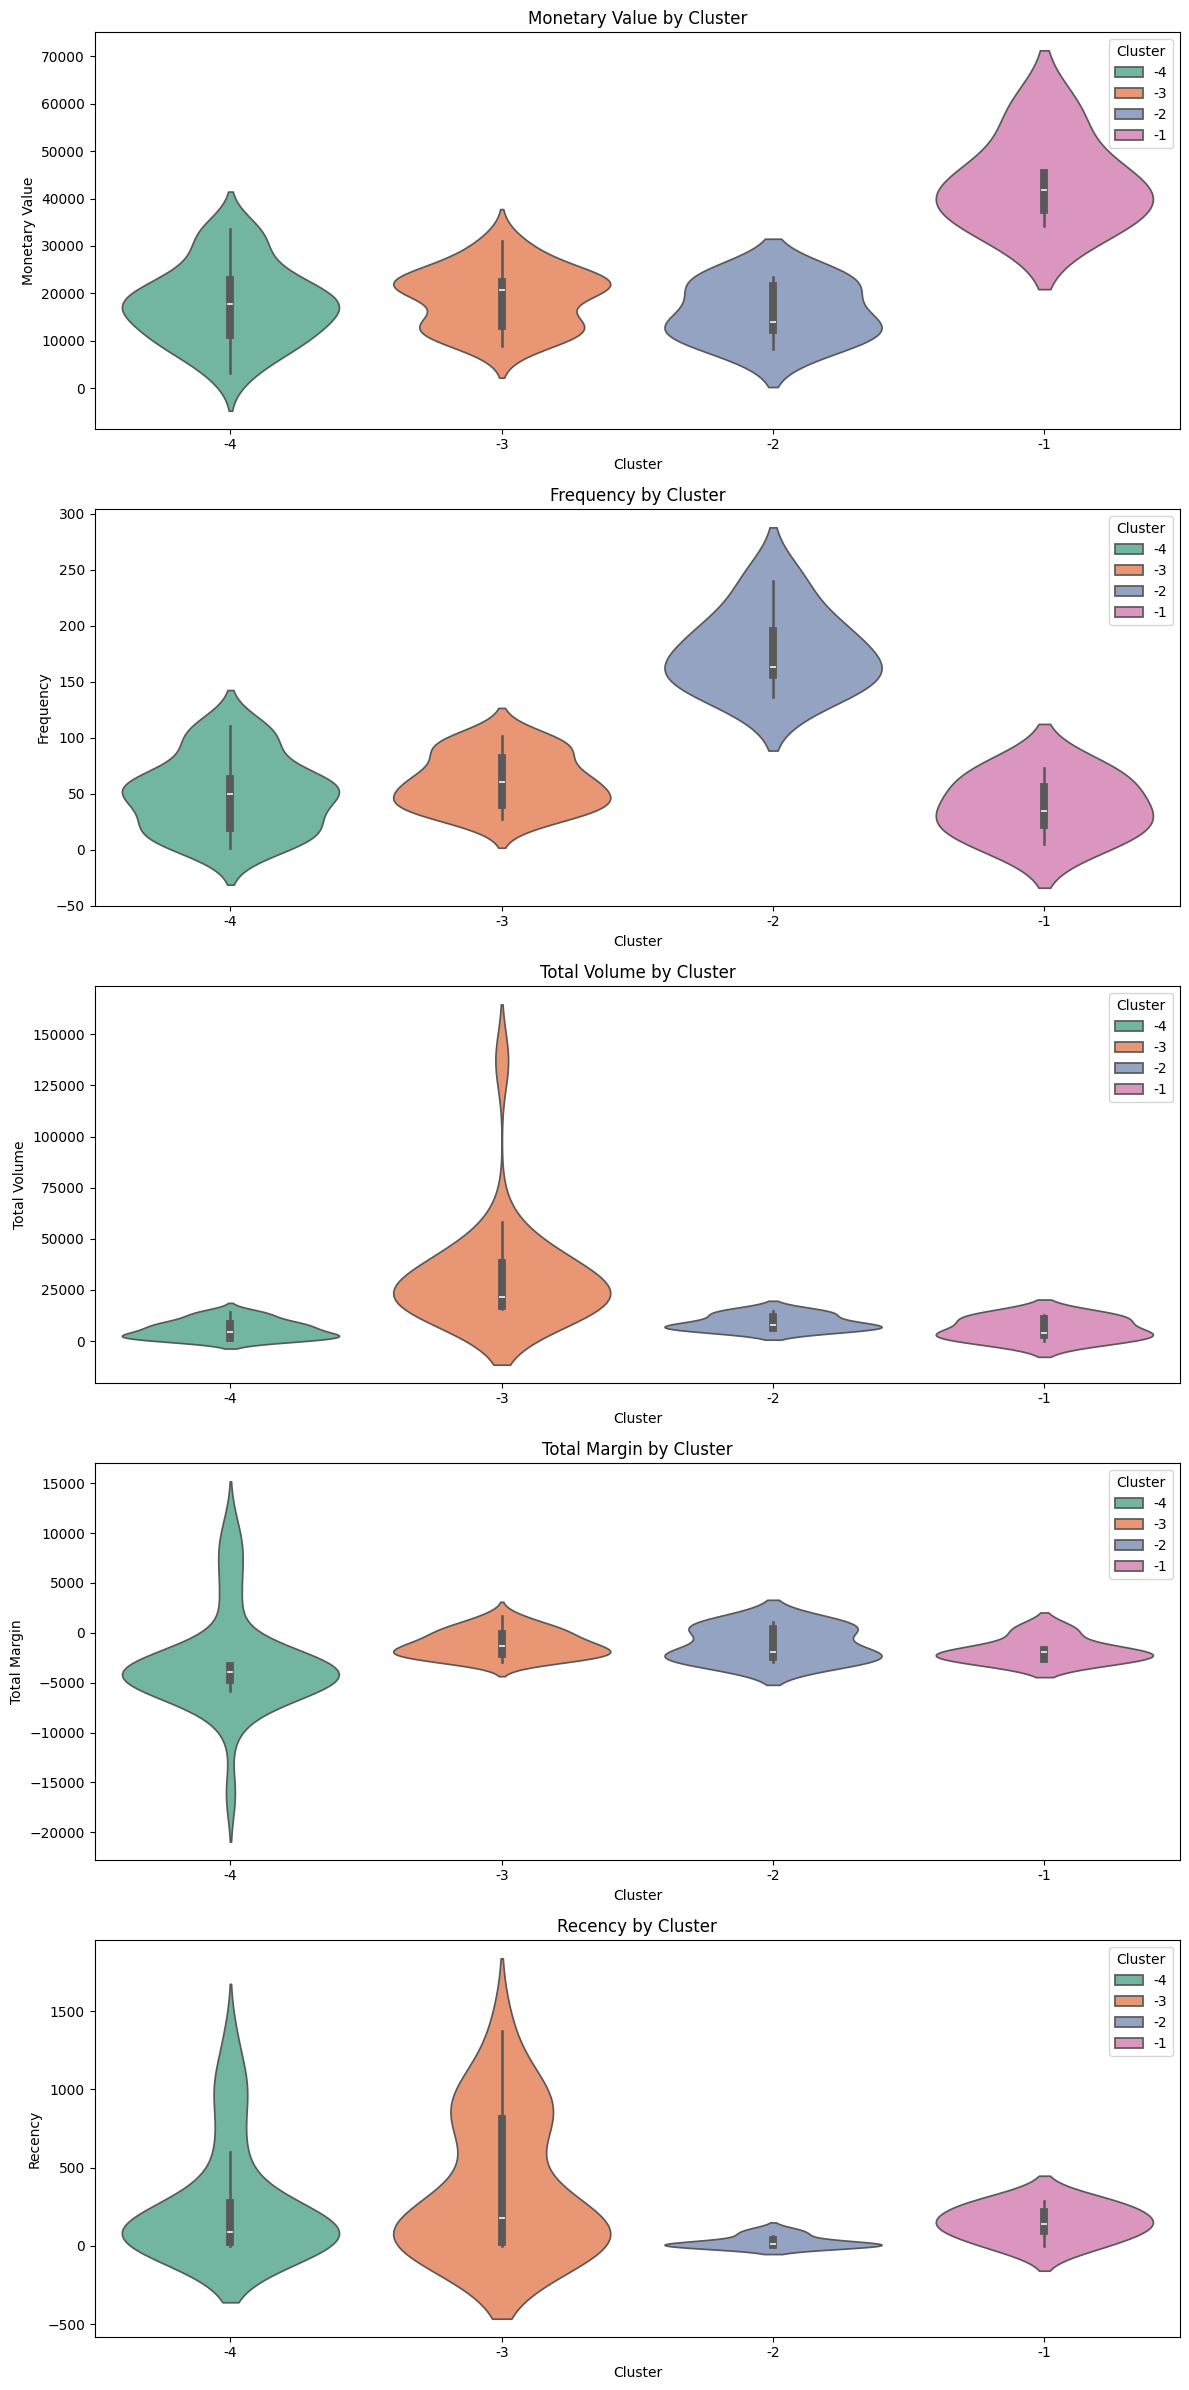

In [29]:
# Create a figure with subplots for each variable
plt.figure(figsize=(12, 24))  # Adjust height to accommodate the five plots

# Plot for Monetary Value
plt.subplot(5, 1, 1)
sns.violinplot(x='Cluster', y='Monetary', data=outlier_clusters_df, hue='Cluster', dodge=False, palette='Set2')
plt.title('Monetary Value by Cluster')
plt.ylabel('Monetary Value')

# Plot for Frequency
plt.subplot(5, 1, 2)
sns.violinplot(x='Cluster', y='Frequency', data=outlier_clusters_df, hue='Cluster', dodge=False, palette='Set2')
plt.title('Frequency by Cluster')
plt.ylabel('Frequency')

# Plot for Recency
plt.subplot(5, 1, 5)
sns.violinplot(x='Cluster', y='Recency', data=outlier_clusters_df, hue='Cluster', dodge=False, palette='Set2')
plt.title('Recency by Cluster')
plt.ylabel('Recency')

# Plot for Total Volume
plt.subplot(5, 1, 3)
sns.violinplot(x='Cluster', y='TotalVolume', data=outlier_clusters_df, hue='Cluster', dodge=False, palette='Set2')
plt.title('Total Volume by Cluster')
plt.ylabel('Total Volume')

# Plot for Total Margin
plt.subplot(5, 1, 4)
sns.violinplot(x='Cluster', y='TotalMargin', data=outlier_clusters_df, hue='Cluster', dodge=False, palette='Set2')
plt.title('Total Margin by Cluster')
plt.ylabel('Total Margin')


# Display all subplots with tight layout
plt.tight_layout()
plt.show()


# Cluster Analysis and Recommended Business Strategies for our outliers

We analyzed customer segments based on **Monetary Value**, **Frequency**, **Total Volume**, **Total Margin**, and **Recency**. Each cluster has been labeled according to these characteristics, providing insights into customer behavior, profitability, and engagement. The following table outlines each cluster’s key traits, label, and potential business actions to optimize engagement and revenue.

| Cluster | Label                                     | Description                                                                                                           | Recommended Strategy                                                                                                   |
|---------|-------------------------------------------|-----------------------------------------------------------------------------------------------------------------------|------------------------------------------------------------------------------------------------------------------------|
| -1      | **High-Value, High-Margin Premium Customers** | These customers contribute significantly to revenue through large, high-margin purchases, though they shop less frequently. They are recent or active, indicating sustained engagement. | **Retention & VIP Treatment**: Provide personalized offers, VIP experiences, and loyalty rewards. Focus on retaining these high-value customers through exclusive perks and personalized service. |
| -2      | **Loyal, High-Frequency Retail Customers** | Engaged, frequent shoppers with moderate spending per transaction. Their regular engagement contributes to consistent revenue and profitability. They buy in low to moderate volumes, indicating retail (not bulk) purchases. | **Loyalty Program & Upselling**: Enhance loyalty with point-based rewards or tiered benefits. Encourage upselling and cross-selling through tailored product recommendations and targeted marketing campaigns to increase average order value. |
| -3      | **Bulk Buyers at Risk**                   | These customers purchase large quantities but are currently inactive, indicating they may have switched to competitors or may not need frequent resupply. Their margin is variable, possibly due to bulk discounts. | **Reactivation Campaign**: Reach out with personalized re-engagement offers or discounts on bulk purchases. Consider re-engagement campaigns emphasizing the benefits of returning (e.g., discounts, loyalty bonuses, or tailored volume-based offers). |
| -4      | **Occasional, Price-Sensitive Shoppers**  | These are infrequent buyers who likely respond to promotions or discounts. They have a mixed to low profitability profile, suggesting sensitivity to pricing. Their engagement is low, and they buy moderate volumes when they do engage. | **Promotions & Seasonal Discounts**: Attract these customers with seasonal promotions, flash sales, and discounts. Use email or SMS marketing to highlight discounts and limited-time offers, and test different promotional strategies to see what engages them most effectively. |

### Detailed Summary of Cluster Labels and Strategies

Each cluster provides an opportunity to implement targeted marketing and customer engagement strategies:

- **Cluster -1**: **High-Value, High-Margin Premium Customers**
  - These customers are highly valuable due to their high spending and margin per transaction. They are often low in frequency but still active, indicating they make fewer, larger purchases.
  - **Strategy**: Focus on **retention** by offering exclusive benefits, such as early access to new products, invitations to events, or priority support. Treat these customers as VIPs, offering personalized recommendations and premium services to ensure they remain loyal.

- **Cluster -2**: **Loyal, High-Frequency Retail Customers**
  - This group is composed of regular, engaged buyers who may not spend as much per transaction as Cluster -1 but contribute through frequency and reliability. Their stable profitability makes them a strong foundation for regular revenue.
  - **Strategy**: **Strengthen loyalty** with a rewards program or regular incentives. Aim to increase their average order value by offering targeted upsell opportunities or bundles that encourage them to spend more on each purchase.

- **Cluster -3**: **Bulk Buyers at Risk**
  - Bulk buyers are likely businesses or individuals who purchase in large volumes, often with discounted pricing that impacts margin. Their high recency indicates a lack of recent engagement, making them at-risk.
  - **Strategy**: Implement a **reactivation campaign** with offers tailored to bulk buyers, such as volume discounts, loyalty-based discounts, or reminders of previous purchases. Highlight any new bulk discounts or time-limited offers that incentivize re-engagement.

- **Cluster -4**: **Occasional, Price-Sensitive Shoppers**
  - This group engages sporadically and is likely driven by discounts or promotions. They exhibit mixed profitability, with some transactions potentially being unprofitable, likely due to heavy discounts.
  - **Strategy**: Use **promotional marketing** to re-engage these customers with seasonal or event-based discounts. Leverage targeted email marketing to showcase special offers, clearance sales, or bundles designed to appeal to their price sensitivity.

### Strategic Insights

By aligning marketing and engagement strategies with each cluster’s profile, businesses can:

- **Maximize retention** for high-value customers by prioritizing their unique needs and providing them with exceptional service.
- **Increase loyalty and spending** among frequent shoppers by creating an emotional connection and incentivizing larger purchases.
- **Reactivate at-risk customers** by addressing specific needs (e.g., bulk discounts) and reminding them of previous positive experiences.
- **Boost revenue from occasional buyers** with seasonal promotions and limited-time offers to encourage more frequent purchases.

This customer segmentation framework provides actionable insights into how to engage and retain each segment effectively, maximizing both immediate and long-term business value.


In [30]:
cluster_labels = {
    0: "High-Value Inactive Customers",
    1: "Low Engagement, Low Value",
    2: "Price-Sensitive Occasional Shoppers",
    3: "Frequent, High-Value Retail Customers",
    4: "High-Volume, Low Margin Buyers",
    5: "Premium, High-Margin Customers",
    6: "Infrequent, High-Margin Niche Buyers",
    -1: "High-Value, High-Margin Premium Customers",
    -2: "Loyal, High-Frequency Retail Customers",
    -3: "Bulk Buyers at Risk",
    -4: "Occasional, Price-Sensitive Shoppers",
}

In [31]:
full_clustering_df = pd.concat([non_outliers_df, outlier_clusters_df])

full_clustering_df

,customer,Monetary,Frequency,LastInvoiceDate,TotalVolume,TotalMargin,Recency,Cluster
0,0,13.72,1,2020-10-06,1,-2.53,1450,1
2,4,3135.02,39,2024-05-03,1315,-736.60,145,6
3,5,2199.45,5,2020-03-06,161,-2220.25,1664,1
4,6,99.48,2,2021-07-02,3,-8.89,1181,1
6,17,205.80,2,2021-04-15,44,-1381.80,1259,1
...,...,...,...,...,...,...,...,...
63,2204,13635.13,14,2024-07-31,3852,-4855.66,56,-4
64,2252,23402.12,63,2024-09-25,4085,-8907.89,0,-4
65,2363,24038.03,13,2024-07-17,1854,-3653.79,70,-4
66,2365,12262.02,9,2023-01-31,1646,6926.88,603,-4


In [32]:
# Map the cluster labels to the 'Cluster' column in the 'full_clustering_df' DataFrame and 
# create a new 'ClusterLabel' column to store the corresponding cluster labels.
full_clustering_df["ClusterLabel"] = full_clustering_df["Cluster"].map(cluster_labels)

full_clustering_df

,customer,Monetary,Frequency,LastInvoiceDate,TotalVolume,TotalMargin,Recency,Cluster,ClusterLabel
0,0,13.72,1,2020-10-06,1,-2.53,1450,1,"Low Engagement, Low Value"
2,4,3135.02,39,2024-05-03,1315,-736.60,145,6,"Infrequent, High-Margin Niche Buyers"
3,5,2199.45,5,2020-03-06,161,-2220.25,1664,1,"Low Engagement, Low Value"
4,6,99.48,2,2021-07-02,3,-8.89,1181,1,"Low Engagement, Low Value"
6,17,205.80,2,2021-04-15,44,-1381.80,1259,1,"Low Engagement, Low Value"
...,...,...,...,...,...,...,...,...,...
63,2204,13635.13,14,2024-07-31,3852,-4855.66,56,-4,"Occasional, Price-Sensitive Shoppers"
64,2252,23402.12,63,2024-09-25,4085,-8907.89,0,-4,"Occasional, Price-Sensitive Shoppers"
65,2363,24038.03,13,2024-07-17,1854,-3653.79,70,-4,"Occasional, Price-Sensitive Shoppers"
66,2365,12262.02,9,2023-01-31,1646,6926.88,603,-4,"Occasional, Price-Sensitive Shoppers"


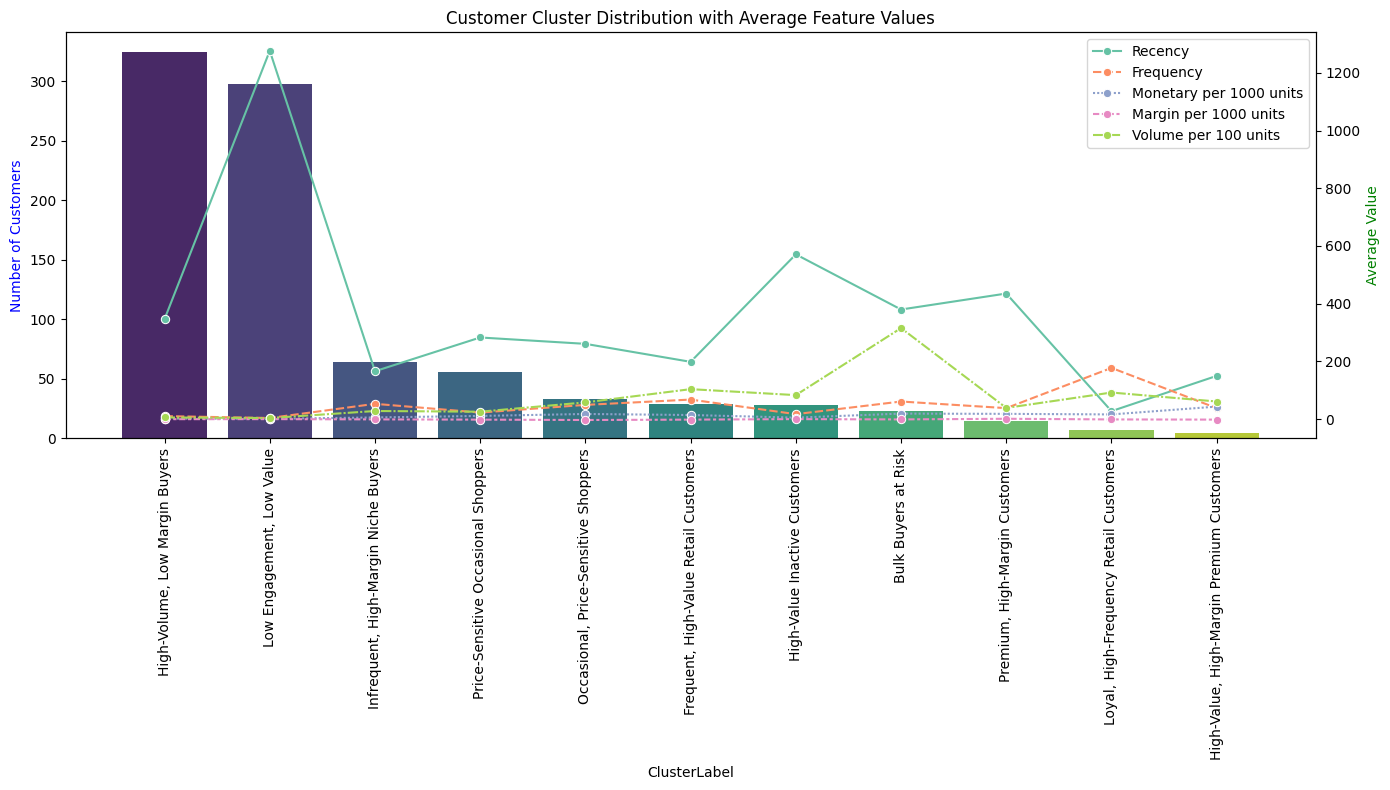

In [33]:
# Map clusters to descriptive labels
full_clustering_df['ClusterLabel'] = full_clustering_df['Cluster'].map(cluster_labels)

# Calculate cluster counts
cluster_counts = full_clustering_df['ClusterLabel'].value_counts()

# Create new columns for scaled Monetary, Margin, and Volume values
full_clustering_df["Monetary per 1000 units"] = full_clustering_df["Monetary"] / 1000.00
full_clustering_df["Margin per 1000 units"] = full_clustering_df["TotalMargin"] / 1000.00
full_clustering_df["Volume per 100 units"] = full_clustering_df["TotalVolume"] / 100.00

# Calculate feature means by cluster label
feature_means = full_clustering_df.groupby('ClusterLabel')[['Recency', 'Frequency', 'Monetary per 1000 units', 'Margin per 1000 units', 'Volume per 100 units']].mean()

# Plotting
fig, ax1 = plt.subplots(figsize=(14, 8))

# Bar plot for cluster distribution
sns.barplot(x=cluster_counts.index, y=cluster_counts.values, ax=ax1, palette='viridis', hue=cluster_counts.index)
ax1.set_ylabel('Number of Customers', color='b')
ax1.set_title('Customer Cluster Distribution with Average Feature Values')

# Rotate x-axis labels vertically for readability
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)

# Line plot for average feature values on a secondary y-axis
ax2 = ax1.twinx()
sns.lineplot(data=feature_means, ax=ax2, palette='Set2', marker='o')
ax2.set_ylabel('Average Value', color='g')

# Display the plot
plt.tight_layout()
plt.show()



# Customer Segmentation Analysis

### 1. Which customer cluster represents the most valuable segment for the business in terms of revenue potential?

Based on the graph, the **"Premium, High-Margin Customers"** cluster has the highest values for metrics like **margin per 1000 units** and **monetary value per 1000 units**. This suggests that this cluster represents the most valuable segment in terms of revenue potential for the business.

---

### 2. Are there any customer segments that the business should focus on retaining or cross-selling to?

The **"Occasional, Price-Sensitive Shoppers"** cluster has relatively high **recency** and **frequency** values compared to some other clusters. This indicates that they are engaged customers, so the business may want to focus on **retaining** and **cross-selling** to this segment.

---

### 3. Which customer cluster would be the most suitable target for a new premium product offering?

The **"Premium, High-Margin Customers"** cluster would likely be the most suitable target for a new **premium product offering**, given their higher **margin per 1000 units** and **monetary value per 1000 units** metrics.

---

### 4. Are there any customer segments that could benefit from more targeted marketing or promotions to increase their engagement?

The **"Low Average Order Value"** cluster has relatively **low values** across multiple metrics like **recency**, **frequency**, and **margin**. This suggests that this segment could potentially benefit from more **targeted marketing** or **promotions** to increase their engagement and spending.


### Code Ends: Masoud Rezapour Najafi $ Ferdinand iguodala
